In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip install category_encoders

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb
import shap
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')


In [16]:
train_df = pd.read_csv("/content/drive/MyDrive/DS Projects/WiDS/widsdatathon2024-challenge2/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/DS Projects/WiDS/widsdatathon2024-challenge2/test.csv")

In [17]:
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

Train dataset shape: (13173, 152)
Test dataset shape: (5646, 151)


In [18]:
train_df.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,Region,Division,patient_age,patient_gender,bmi,...,Average of Apr-18,Average of May-18,Average of Jun-18,Average of Jul-18,Average of Aug-18,Average of Sep-18,Average of Oct-18,Average of Nov-18,Average of Dec-18,metastatic_diagnosis_period
0,268700,NaN,COMMERCIAL,AR,724,South,West South Central,39,F,NaN,...,52.55,74.77,79.96,81.69,78.30,74.56,59.98,42.98,41.18,191
1,484983,White,NaN,IL,629,Midwest,East North Central,55,F,35.36,...,49.30,72.87,77.40,77.43,75.83,72.64,58.36,39.68,39.71,33
2,277055,NaN,COMMERCIAL,CA,925,West,Pacific,59,F,NaN,...,68.50,70.31,78.61,87.24,85.52,80.75,70.81,62.67,55.58,157
3,320055,Hispanic,MEDICAID,CA,900,West,Pacific,59,F,NaN,...,63.34,63.10,67.45,75.86,75.24,71.10,68.95,65.46,59.46,146
4,190386,NaN,COMMERCIAL,CA,934,West,Pacific,71,F,NaN,...,59.45,60.24,64.77,69.81,70.13,68.10,65.38,60.72,54.08,286


In [19]:
 # Check for missing values in target
missing_target = train_df['metastatic_diagnosis_period'].isnull().sum()
if missing_target > 0:
  print(f"\nWarning: {missing_target} missing values in target variable")

In [20]:
train_df['metastatic_diagnosis_period'].describe()

,metastatic_diagnosis_period
count,13173.000000
mean,96.515221
std,108.969873
min,0.000000
25%,3.000000
50%,44.000000
75%,181.000000
max,365.000000


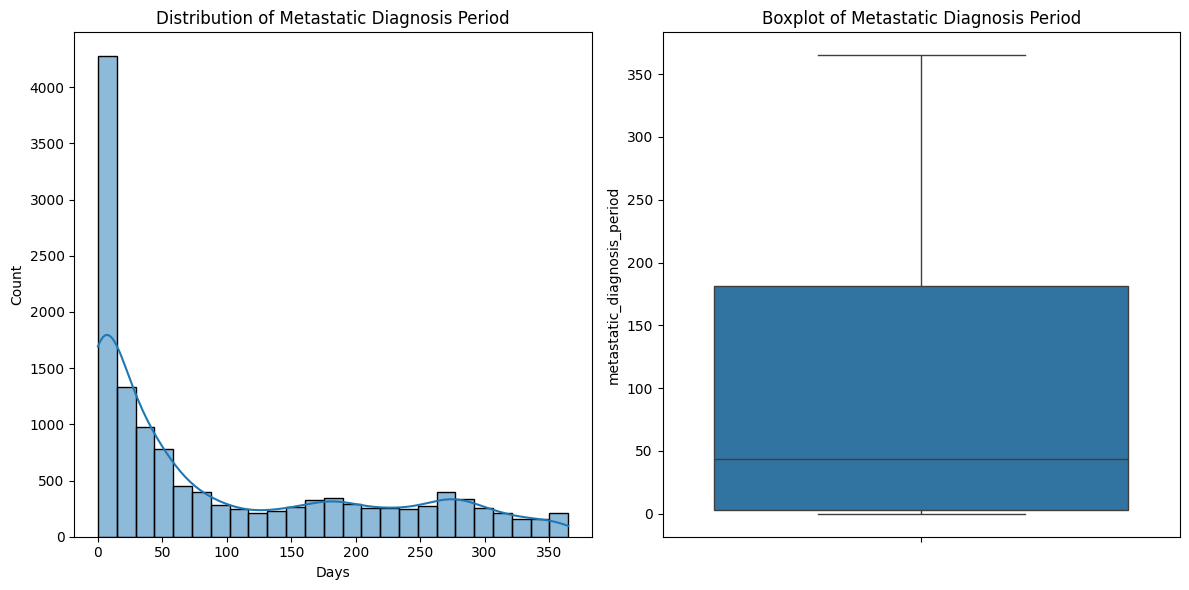

In [21]:
# Visualize target distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_df['metastatic_diagnosis_period'].dropna(), kde=True)
plt.title('Distribution of Metastatic Diagnosis Period')
plt.xlabel('Days')

plt.subplot(1, 2, 2)
sns.boxplot(y=train_df['metastatic_diagnosis_period'].dropna())
plt.title('Boxplot of Metastatic Diagnosis Period')
plt.tight_layout()
plt.show()


## 2. Advanced Data Preprocessing

In [22]:
processed_train = train_df.copy()
processed_test = test_df.copy()

In [23]:
# Handle missing values in target if training data
if 'metastatic_diagnosis_period' in processed_train.columns and processed_train['metastatic_diagnosis_period'].isnull().sum() > 0:
    print(f"Dropping {processed_train['metastatic_diagnosis_period'].isnull().sum()} rows with missing target values")
    processed_train = processed_train.dropna(subset=['metastatic_diagnosis_period'])

In [24]:
# Age groups
if 'patient_age' in processed_train.columns:
    processed_train['age_group'] = pd.cut(
        processed_train['patient_age'],
        bins=[0, 40, 50, 60, 70, 80, 120],
        labels=['Under 40', '40-50', '50-60', '60-70', '70-80', 'Over 80']
    )

In [25]:
# Extract information from diagnosis codes
if 'breast_cancer_diagnosis_code' in processed_train.columns:
    processed_train['diagnosis_code_prefix'] = processed_train['breast_cancer_diagnosis_code'].astype(str).str[:3]

if 'metastatic_cancer_diagnosis_code' in processed_train.columns:
    processed_train['metastatic_code_prefix'] = processed_train['metastatic_cancer_diagnosis_code'].astype(str).str[:3]

# Create socioeconomic status indicator
if all(col in processed_train.columns for col in ['income_household_median', 'education_college_or_above']):
    # Handle missing values in these columns before normalization
    income_median = processed_train['income_household_median'].copy()
    if income_median.isnull().any():
        income_median = income_median.fillna(income_median.median())

    education = processed_train['education_college_or_above'].copy()
    if education.isnull().any():
        education = education.fillna(education.median())

    # Normalize income and education
    income_min = income_median.min()
    income_max = income_median.max()

    if income_max > income_min:  # Prevent division by zero
        income_norm = (income_median - income_min) / (income_max - income_min)
        education_norm = education / 100  # Assuming education is a percentage

        # Simple combined SES score
        processed_train['ses_score'] = (income_norm + education_norm) / 2

# Calculate temperature variation as potential environmental factor
temp_columns = [col for col in processed_train.columns if col.startswith('Average of')]
if temp_columns:
    processed_train['temp_mean'] = processed_train[temp_columns].mean(axis=1, skipna=True)
    processed_train['temp_std'] = processed_train[temp_columns].std(axis=1, skipna=True)
    processed_train['temp_range'] = processed_train[temp_columns].max(axis=1, skipna=True) - processed_train[temp_columns].min(axis=1, skipna=True)


In [26]:
if 'patient_age' in processed_test.columns:
    processed_test['age_group'] = pd.cut(
        processed_test['patient_age'],
        bins=[0, 40, 50, 60, 70, 80, 120],
        labels=['Under 40', '40-50', '50-60', '60-70', '70-80', 'Over 80']
    )

# Extract information from diagnosis codes
if 'breast_cancer_diagnosis_code' in processed_test.columns:
    processed_test['diagnosis_code_prefix'] = processed_test['breast_cancer_diagnosis_code'].astype(str).str[:3]

if 'metastatic_cancer_diagnosis_code' in processed_test.columns:
    processed_test['metastatic_code_prefix'] = processed_test['metastatic_cancer_diagnosis_code'].astype(str).str[:3]

# Create socioeconomic status indicator
if all(col in processed_test.columns for col in ['income_household_median', 'education_college_or_above']):
    # Handle missing values
    income_median = processed_test['income_household_median'].copy()
    if income_median.isnull().any():
        income_median = income_median.fillna(income_median.median())

    education = processed_test['education_college_or_above'].copy()
    if education.isnull().any():
        education = education.fillna(education.median())

    # Normalize using same min/max as train
    income_min = processed_train['income_household_median'].min()
    income_max = processed_train['income_household_median'].max()

    if income_max > income_min:
        income_norm = (income_median - income_min) / (income_max - income_min)
        education_norm = education / 100
        processed_test['ses_score'] = (income_norm + education_norm) / 2

# Calculate temperature variation for test
if temp_columns:
    processed_test['temp_mean'] = processed_test[temp_columns].mean(axis=1, skipna=True)
    processed_test['temp_std'] = processed_test[temp_columns].std(axis=1, skipna=True)
    processed_test['temp_range'] = processed_test[temp_columns].max(axis=1, skipna=True) - processed_test[temp_columns].min(axis=1, skipna=True)


## 3. Selecting features

In [27]:
# Define feature groups
demographic_features = ['patient_age', 'patient_gender', 'patient_race', 'bmi']

location_features = [
    'patient_state', 'region', 'division',
    'population', 'density'
]

socioeconomic_features = [
    'income_household_median', 'education_college_or_above',
    'poverty', 'unemployment_rate', 'health_uninsured',
    'rent_burden', 'home_ownership'
]

clinical_features = [
    'payer_type', 'metastatic_first_novel_treatment_type',
    'diagnosis_code_prefix', 'metastatic_code_prefix'
]

engineered_features = [
    'age_group', 'ses_score', 'temp_mean', 'temp_std', 'temp_range'
]


In [28]:
# Filter to only include columns that exist in both dataframes
all_features_list = demographic_features + location_features + socioeconomic_features + clinical_features + engineered_features
available_features = [f for f in all_features_list if f in processed_train.columns and f in processed_test.columns]

In [29]:
# Handle high cardinality ZIP codes with target encoding
target_encoder = None
if 'patient_zip3' in processed_train.columns and 'patient_zip3' in processed_test.columns:
    # Create and fit encoder on training data
    target_encoder = ce.TargetEncoder()
    target_encoder.fit(processed_train['patient_zip3'], processed_train['metastatic_diagnosis_period'])

    # Apply encoding to both train and test
    processed_train['zip3_encoded'] = target_encoder.transform(processed_train['patient_zip3'])
    processed_test['zip3_encoded'] = target_encoder.transform(processed_test['patient_zip3'])

    # Add to available features
    available_features.append('zip3_encoded')

In [30]:
# Remove features with high percentage of missing values in train
missing_percentage = processed_train[available_features].isnull().mean()
high_missing = missing_percentage[missing_percentage > 0.3].index.tolist()

if high_missing:
    print(f"Removing features with >30% missing values: {high_missing}")
    available_features = [f for f in available_features if f not in high_missing]

Removing features with >30% missing values: ['patient_race', 'bmi', 'metastatic_first_novel_treatment_type']


In [31]:
# Create X datasets
X_train = processed_train[available_features]
X_test = processed_test[available_features]

In [32]:
# Create y for training
y_train = processed_train['metastatic_diagnosis_period']

In [33]:
# Identify categorical and numerical features
categorical_features = []
numerical_features = []

for feature in available_features:
    if feature in X_train.columns:  # Ensure the feature exists
        if X_train[feature].dtype == 'object' or X_train[feature].dtype.name == 'category':
            categorical_features.append(feature)
        elif X_train[feature].dtype in ['int64', 'float64']:
            numerical_features.append(feature)

print(f"\nUsing {len(available_features)} features:")
print(f"- {len(numerical_features)} numerical features")
print(f"- {len(categorical_features)} categorical features")



Using 21 features:
- 15 numerical features
- 6 categorical features


## 4. Build ML Pipeline

In [34]:
# Numerical features pipeline with KNN imputation
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

In [35]:
# Categorical features pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [36]:
# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Drop any columns not specified
)


### Create multiple model pipelines

In [37]:
# 1. LightGBM
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(objective='regression', n_estimators=200,
                                learning_rate=0.05, num_leaves=31,
                                random_state=42))
])

# 2. XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200,
                              learning_rate=0.05, max_depth=6,
                              random_state=42))
])

# 3. Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, max_depth=None,
                                   min_samples_leaf=1, min_samples_split=2,
                                   random_state=42, n_jobs=-1))
])

# 4. Gradient Boosting
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators=200, learning_rate=0.05,
                                       max_depth=4, subsample=0.8,
                                       random_state=42))
])

pipelines = {
    'LightGBM': lgb_pipeline,
    'XGBoost': xgb_pipeline,
    'RandomForest': rf_pipeline,
    'GradientBoosting': gb_pipeline
}


## 5. Train and evaluate models

In [38]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [39]:
results = {}
trained_models = {}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, pipeline in pipelines.items():
    print(f"\nTraining and evaluating {name}...")

    # Cross-validation
    cv_scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=cv, scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    # Convert negative MAE to positive
    cv_mae = -cv_scores.mean()
    cv_std = cv_scores.std()

    print(f"{name} Cross-Validation MAE: {cv_mae:.2f} ± {cv_std:.2f}")

    # Train on full training data
    pipeline.fit(X_train, y_train)

    # Store results and trained model
    results[name] = {
        'CV_MAE': cv_mae,
        'CV_STD': cv_std
    }

    trained_models[name] = pipeline


Training and evaluating LightGBM...
LightGBM Cross-Validation MAE: 63.10 ± 0.96
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3683
[LightGBM] [Info] Number of data points in the train set: 13173, number of used features: 67
[LightGBM] [Info] Start training from score 96.515221

Training and evaluating XGBoost...
XGBoost Cross-Validation MAE: 63.28 ± 1.02

Training and evaluating RandomForest...
RandomForest Cross-Validation MAE: 67.99 ± 0.98

Training and evaluating GradientBoosting...
GradientBoosting Cross-Validation MAE: 63.09 ± 1.01


In [40]:
# Create a comparison dataframe
results_df = pd.DataFrame({
    model: {'CV MAE': results[model]['CV_MAE']} for model in results
}).T.sort_values('CV MAE')

print("\nModel Comparison:")
print(results_df)


Model Comparison:
                     CV MAE
GradientBoosting  63.094116
LightGBM          63.102986
XGBoost           63.284162
RandomForest      67.993229


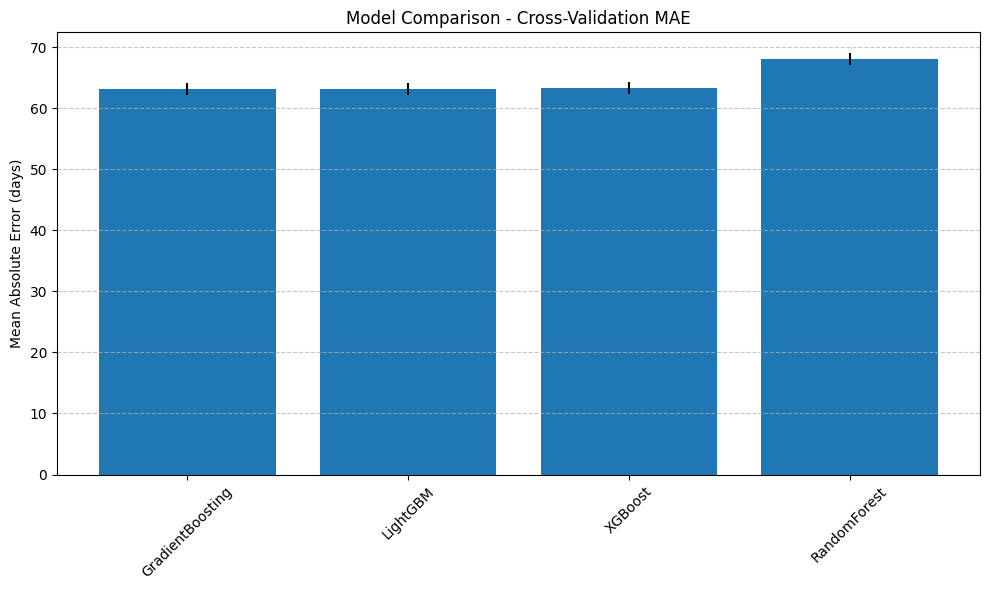

In [41]:
# Plot results
plt.figure(figsize=(10, 6))
plt.bar(results_df.index, results_df['CV MAE'], yerr=results_df.index.map(lambda x: results[x]['CV_STD']))
plt.title('Model Comparison - Cross-Validation MAE')
plt.ylabel('Mean Absolute Error (days)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [42]:
# Find the best model
best_model_name = results_df.index[0]  # Model with lowest MAE
best_model = trained_models[best_model_name]

print(f"\nBest model: {best_model_name}")



Best model: GradientBoosting


## 6. Analyze Feature Importance

In [43]:
# Get feature names after preprocessing
preprocessor = best_model.named_steps['preprocessor']
model = best_model.named_steps['model']

In [44]:
# Apply preprocessing to get transformed feature names
X_train_processed = preprocessor.transform(X_train)

In [45]:
# Get feature names
all_feature_names = numerical_features.copy()

In [46]:
if categorical_features:
    # Get the categorical encoder
    cat_transformer = preprocessor.named_transformers_.get('cat')
    if cat_transformer is not None:
        encoder = cat_transformer.named_steps.get('encoder')
        if encoder is not None:
            # Get encoded feature names
            encoded_features = encoder.get_feature_names_out(categorical_features)
            all_feature_names.extend(encoded_features)

In [47]:
# Ensure we have the right number of feature names
all_feature_names = all_feature_names[:X_train_processed.shape[1]]


Top 15 important features:
diagnosis_code_prefix_C50     0.769318
diagnosis_code_prefix_174     0.064573
patient_age                   0.039843
zip3_encoded                  0.012748
rent_burden                   0.007924
unemployment_rate             0.007605
home_ownership                0.007341
education_college_or_above    0.007218
temp_mean                     0.006942
poverty                       0.005549
income_household_median       0.005468
ses_score                     0.005279
temp_std                      0.004978
population                    0.004969
health_uninsured              0.004525
dtype: float64


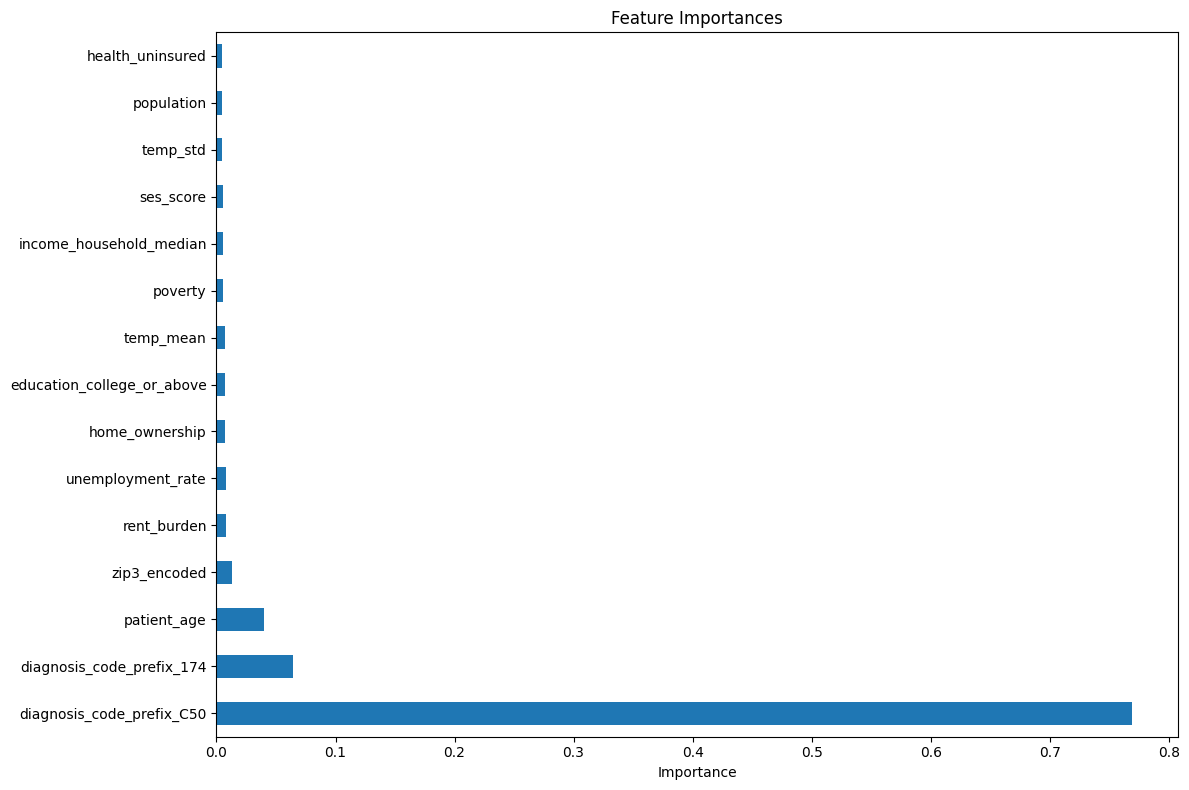

In [48]:
# Get feature importances if the model supports it
feature_importances = None
if hasattr(model, 'feature_importances_'):
    feature_importances = pd.Series(
        model.feature_importances_,
        index=all_feature_names
    ).sort_values(ascending=False)

    print("\nTop 15 important features:")
    print(feature_importances.head(15))

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    feature_importances.head(15).plot(kind='barh')
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
else:
    print("This model doesn't provide feature importances.")

## 7. Generate Predictions for Test Data

In [49]:
predictions = {}

In [50]:
# Generate predictions for each model
for name, model in trained_models.items():
    predictions[name] = model.predict(X_test)

In [51]:
# Create a dataframe with all predictions
pred_df = pd.DataFrame({
    'patient_id': test_df['patient_id'],
})

In [52]:
# Add predictions from each model
for name, preds in predictions.items():
    pred_df[f'{name}_prediction'] = preds

In [53]:
# Add ensemble prediction (average of all models)
pred_columns = [f'{name}_prediction' for name in trained_models.keys()]
pred_df['ensemble_prediction'] = pred_df[pred_columns].mean(axis=1)

In [54]:
# Create the solution file format with patient_id and metastatic_diagnosis_period
solution_df = pd.DataFrame({
    'patient_id': test_df['patient_id'],
    'metastatic_diagnosis_period': pred_df['ensemble_prediction'].round().astype(int)
})

print("\nSolution file preview:")
print(solution_df.head())


Solution file preview:
   patient_id  metastatic_diagnosis_period
0      730681                          159
1      334212                           59
2      571362                          210
3      907331                          238
4      208382                           42


## 8. Create detailed visualization of feature importance

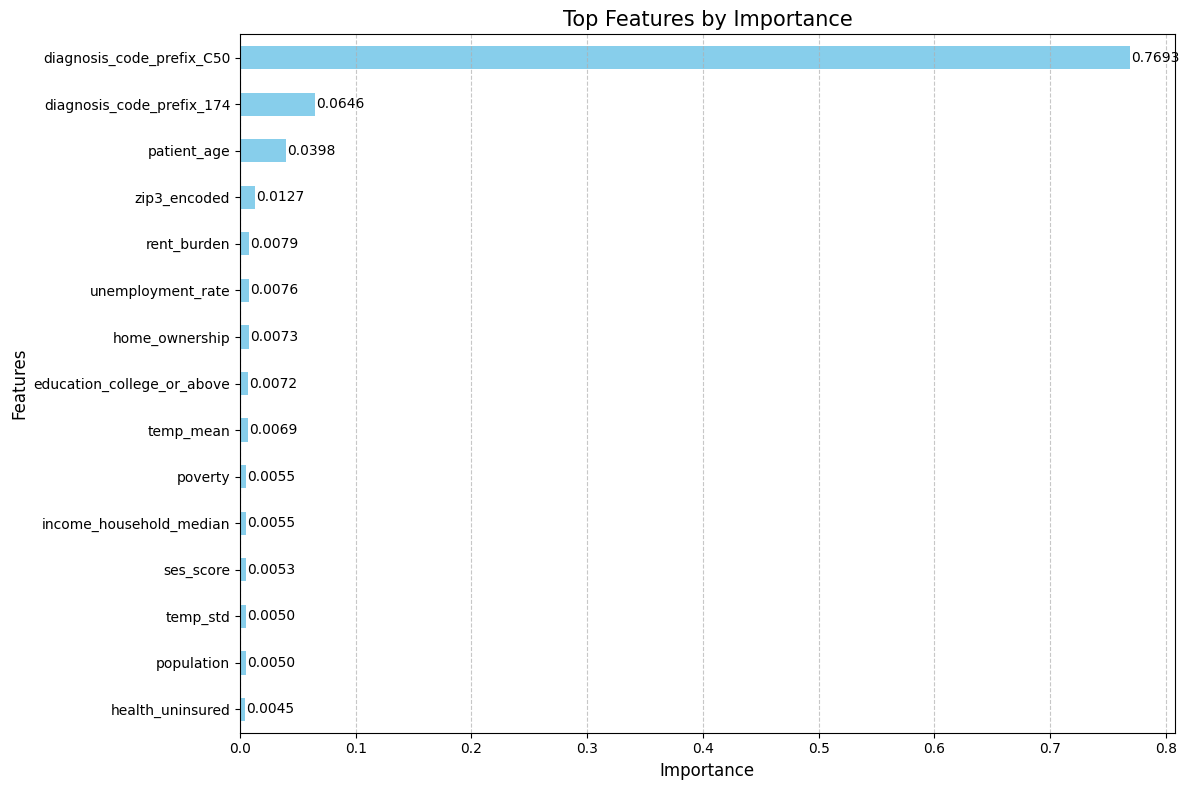

In [55]:
if feature_importances is not None:
    # Get top features
    top_n = 15
    top_features = feature_importances.head(top_n)

    # Create a more visually appealing plot
    plt.figure(figsize=(12, 8))
    ax = top_features.sort_values().plot(kind='barh', color='skyblue')

    # Add values to the bars
    for i, v in enumerate(top_features.sort_values()):
        ax.text(v + 0.001, i, f'{v:.4f}', color='black', va='center')

    plt.title('Top Features by Importance', fontsize=15)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## 10. Save the final solution

In [56]:
# Define the path for the new solutions.csv file
solution_path = '/content/drive/MyDrive/DS Projects/WiDS/widsdatathon2024-challenge2/solutions.csv'

# Save the DataFrame to the new CSV file
solution_df.to_csv(solution_path, index=False)
print(f"Tuned solution saved to {solution_path}")

Tuned solution saved to /content/drive/MyDrive/DS Projects/WiDS/widsdatathon2024-challenge2/solutions.csv
